# UTS: Document Clustering on Email/SMS Data

**Pipeline:** load → clean text → TF‑IDF → choose K (elbow + silhouette) → KMeans clustering → top terms per cluster → 2D PCA plot → export results.

> Catatan: Grafik menggunakan matplotlib standar (tanpa style/warna khusus).

In [1]:
# 1) Imports & Setup
import re
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

DATA_PATH = Path('datasets/spam.csv')
RANDOM_STATE = 42
pd.set_option('display.max_colwidth', 120)

In [2]:
# 2) Load dataset
df_raw = pd.read_csv(DATA_PATH, encoding='latin1')

# Keep only the essential columns
cols = [c for c in df_raw.columns if c.lower() in ['id', 'text']]
df = df_raw[cols].rename(columns={cols[0]:'id', cols[1]:'Text'}) if set(cols)==set(['id','Text']) or set(cols)==set(['id','text']) else df_raw[['id','Text']]

# Drop missing or empty Text
df = df.dropna(subset=['Text']).copy()
df['Text'] = df['Text'].astype(str)
print(df.shape)
df.head()

(5572, 2)


,id,Text
0,1,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat..."
1,2,Ok lar... Joking wif u oni...
2,3,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std t...
3,4,U dun say so early hor... U c already then say...
4,5,"Nah I don't think he goes to usf, he lives around here though"


In [3]:
# 3) Text cleaning util
def clean_text(s: str) -> str:
    s = s.lower()
    s = re.sub(r'https?://\S+|www\.\S+', ' ', s)      # URLs
    s = re.sub(r'\S+@\S+', ' ', s)                     # emails
    s = re.sub(r"[^a-z\s]", ' ', s)                    # keep letters and spaces
    s = re.sub(r'\s+', ' ', s).strip()
    return s

df['clean'] = df['Text'].apply(clean_text)
df[['id','Text','clean']].head(10)

,id,Text,clean
0,1,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...",go until jurong point crazy available only in bugis n great world la e buffet cine there got amore wat
1,2,Ok lar... Joking wif u oni...,ok lar joking wif u oni
2,3,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std t...,free entry in a wkly comp to win fa cup final tkts st may text fa to to receive entry question std txt rate t c s ap...
3,4,U dun say so early hor... U c already then say...,u dun say so early hor u c already then say
4,5,"Nah I don't think he goes to usf, he lives around here though",nah i don t think he goes to usf he lives around here though
5,6,FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX...,freemsg hey there darling it s been week s now and no word back i d like some fun you up for it still tb ok xxx std ...
6,7,Even my brother is not like to speak with me. They treat me like aids patent.,even my brother is not like to speak with me they treat me like aids patent
7,8,As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your callertune for all Calle...,as per your request melle melle oru minnaminunginte nurungu vettam has been set as your callertune for all callers p...
8,9,WINNER!! As a valued network customer you have been selected to receivea å£900 prize reward! To claim call 090617014...,winner as a valued network customer you have been selected to receivea prize reward to claim call claim code kl vali...
9,10,Had your mobile 11 months or more? U R entitled to Update to the latest colour mobiles with camera for Free! Call Th...,had your mobile months or more u r entitled to update to the latest colour mobiles with camera for free call the mob...


In [4]:
    # 4) TF-IDF Vectorization (English stopwords)
tfidf = TfidfVectorizer(stop_words='english', ngram_range=(1,2), min_df=3, max_df=0.9)
X = tfidf.fit_transform(df['clean'])
print('TF-IDF shape:', X.shape)

TF-IDF shape: (5572, 4248)


In [5]:
# 5) Pick K using Elbow (inertia) and Silhouette
inertias = []
sil_scores = []
k_values = list(range(2, 11))
for k in k_values:
    km = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init='auto')
    labels = km.fit_predict(X)
    inertias.append(km.inertia_)
    # To speed up silhouette on large datasets, we can sample, but here we'll compute full
    sil = silhouette_score(X, labels, metric='cosine')
    sil_scores.append(sil)

print('Inertias:', inertias)
print('Silhouettes:', sil_scores)

Inertias: [5406.461305850031, 5390.8915466028575, 5356.969762747466, 5336.395249930182, 5318.023485407949, 5302.017998990318, 5294.41289734448, 5259.095099042778, 5251.99624295513]
Silhouettes: [0.008951589608217191, 0.009976773268926993, 0.008656504957489505, 0.01080590201764069, 0.012797982748356385, 0.014939202685210365, 0.015485448027011675, 0.02030170461711936, 0.020844063679907168]


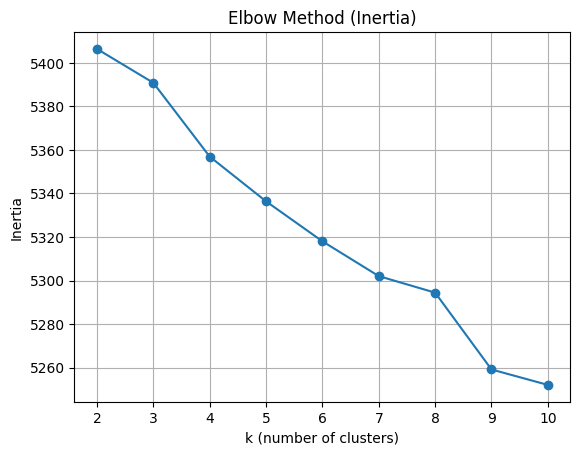

In [6]:
# 6) Plot Elbow (Inertia)
plt.figure()
plt.plot(k_values, inertias, marker='o')
plt.title('Elbow Method (Inertia)')
plt.xlabel('k (number of clusters)')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()

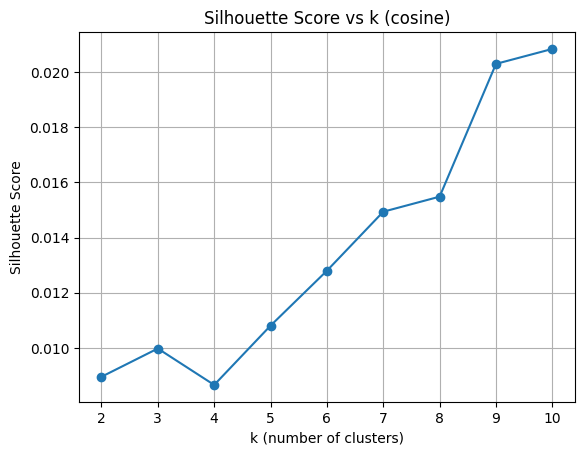

In [7]:
# 7) Plot Silhouette Scores
plt.figure()
plt.plot(k_values, sil_scores, marker='o')
plt.title('Silhouette Score vs k (cosine)')
plt.xlabel('k (number of clusters)')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

In [8]:
# 8) Choose best k (max silhouette)
best_idx = int(np.argmax(sil_scores))
best_k = k_values[best_idx]
print('Best k by silhouette:', best_k)

kmeans = KMeans(n_clusters=best_k, random_state=RANDOM_STATE, n_init='auto')
labels = kmeans.fit_predict(X)
df['cluster'] = labels
df[['id','Text','cluster']].head(10)

Best k by silhouette: 10


,id,Text,cluster
0,1,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...",6
1,2,Ok lar... Joking wif u oni...,8
2,3,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std t...,6
3,4,U dun say so early hor... U c already then say...,6
4,5,"Nah I don't think he goes to usf, he lives around here though",7
5,6,FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX...,0
6,7,Even my brother is not like to speak with me. They treat me like aids patent.,0
7,8,As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your callertune for all Calle...,6
8,9,WINNER!! As a valued network customer you have been selected to receivea å£900 prize reward! To claim call 090617014...,6
9,10,Had your mobile 11 months or more? U R entitled to Update to the latest colour mobiles with camera for Free! Call Th...,6


## Clustering dengan K=2

Berikut adalah hasil clustering dengan 2 cluster sebagai perbandingan:

In [9]:
# Clustering dengan K=2
k_2 = 2
kmeans_2 = KMeans(n_clusters=k_2, random_state=RANDOM_STATE, n_init='auto')
labels_2 = kmeans_2.fit_predict(X)
df['cluster_k2'] = labels_2

# Hitung silhouette score untuk k=2
sil_2 = silhouette_score(X, labels_2, metric='cosine')
print(f'Silhouette Score untuk k=2: {sil_2:.4f}')
print(f'Inertia untuk k=2: {kmeans_2.inertia_:.2f}')
print(f'\nDistribusi cluster (k=2):')
print(df['cluster_k2'].value_counts().sort_index())
df[['id','Text','cluster_k2']].head(10)

Silhouette Score untuk k=2: 0.0090
Inertia untuk k=2: 5406.46

Distribusi cluster (k=2):
cluster_k2
0    5350
1     222
Name: count, dtype: int64


,id,Text,cluster_k2
0,1,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...",0
1,2,Ok lar... Joking wif u oni...,0
2,3,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std t...,0
3,4,U dun say so early hor... U c already then say...,0
4,5,"Nah I don't think he goes to usf, he lives around here though",0
5,6,FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX...,0
6,7,Even my brother is not like to speak with me. They treat me like aids patent.,0
7,8,As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your callertune for all Calle...,0
8,9,WINNER!! As a valued network customer you have been selected to receivea å£900 prize reward! To claim call 090617014...,0
9,10,Had your mobile 11 months or more? U R entitled to Update to the latest colour mobiles with camera for Free! Call Th...,0


In [10]:
# Top terms per cluster untuk K=2
feature_names_2 = np.array(tfidf.get_feature_names_out())
centers_2 = kmeans_2.cluster_centers_
topn_2 = 15
cluster_terms_2 = {}
for c in range(k_2):
    idx = np.argsort(centers_2[c])[::-1][:topn_2]
    cluster_terms_2[c] = feature_names_2[idx].tolist()

print("Top Terms untuk setiap cluster (k=2):")
for c, terms in cluster_terms_2.items():
    print(f"\nCluster {c} top terms:")
    print(', '.join(terms))
    print('-'*60)

Top Terms untuk setiap cluster (k=2):

Cluster 0 top terms:
ok, just, ll, come, ur, good, know, got, like, time, home, going, free, want, sorry
------------------------------------------------------------

Cluster 1 top terms:
gt, lt, lt gt, gt min, lt decimal, decimal gt, decimal, like lt, like, ll, min, gt minutes, minutes, gt mins, gt lt
------------------------------------------------------------


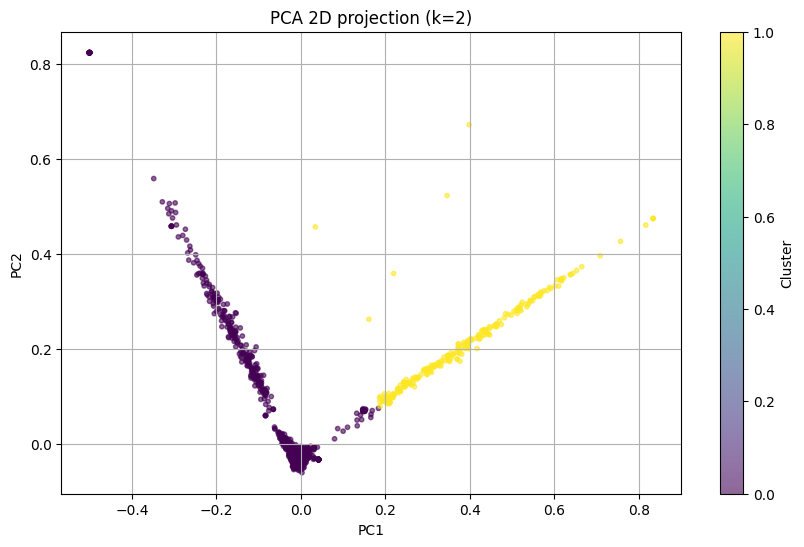

In [11]:
# Visualisasi 2D dengan PCA untuk K=2
pca_2 = PCA(n_components=2, random_state=RANDOM_STATE)
coords_2 = pca_2.fit_transform(X.toarray()) if hasattr(X, 'toarray') else pca_2.fit_transform(X)

plt.figure(figsize=(10, 6))
plt.scatter(coords_2[:,0], coords_2[:,1], s=10, alpha=0.6, c=labels_2, cmap='viridis')
plt.title(f'PCA 2D projection (k=2)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.colorbar(label='Cluster')
plt.grid(True)
plt.show()

## Kluster dengan K Terbaik

In [12]:
# 9) Top terms per cluster
feature_names = np.array(tfidf.get_feature_names_out())
centers = kmeans.cluster_centers_
topn = 15
cluster_terms = {}
for c in range(best_k):
    idx = np.argsort(centers[c])[::-1][:topn]
    cluster_terms[c] = feature_names[idx].tolist()

for c, terms in cluster_terms.items():
    print(f"Cluster {c} top terms:")
    print(', '.join(terms))
    print('-'*60)

Cluster 0 top terms:
like, feel like, feel, dat, dont, like dat, know, dun, just, smile, ok, sounds like, time, send, fr
------------------------------------------------------------
Cluster 1 top terms:
gt, lt, lt gt, gt min, decimal gt, lt decimal, decimal, like lt, min, like, ll, gt minutes, minutes, gt lt, come
------------------------------------------------------------
Cluster 2 top terms:
know, let, let know, don, don know, dont know, dont, lemme know, lemme, want, ll, menu, need, problem, dating service
------------------------------------------------------------
Cluster 3 top terms:
ll later, sorry ll, later, sorry, ll, meeting, later meeting, meeting ll, sorry meeting, bye, fuck, lt gt, aight, lt, gt
------------------------------------------------------------
Cluster 4 top terms:
just, just got, message, right, send, got, free, text, week, phone, ur, send message, tone, ll, phone right
------------------------------------------------------------
Cluster 5 top terms:
going, da

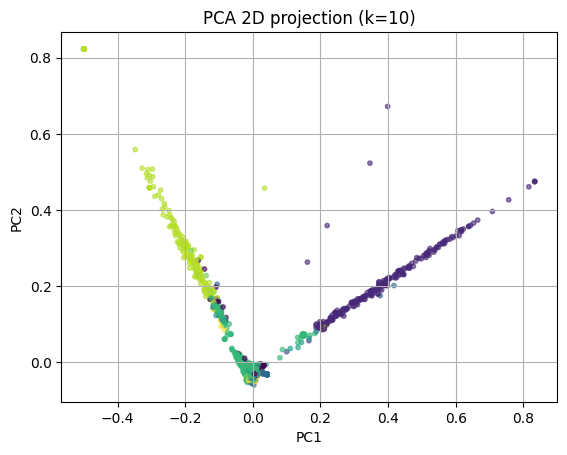

In [13]:
# 10) 2D Visualization with PCA
pca = PCA(n_components=2, random_state=RANDOM_STATE)
coords = pca.fit_transform(X.toarray()) if hasattr(X, 'toarray') else pca.fit_transform(X)

plt.figure()
plt.scatter(coords[:,0], coords[:,1], s=10, alpha=0.6, c=labels)
plt.title(f'PCA 2D projection (k={best_k})')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.grid(True)
plt.show()

In [18]:
# 11) Export clustered results
out_csv = Path('datasets/clustered_spam.csv')
out_2 = Path('datasets/clustered_spam_k2.csv')
df[['id','Text','clean','cluster']].to_csv(out_csv, index=False)
df[['id','Text','clean','cluster_k2']].to_csv(out_2, index=False)
print('Saved')

Saved


,id,Text,clean,cluster,cluster_k2
0,1,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...",go until jurong point crazy available only in bugis n great world la e buffet cine there got amore wat,6,0
1,2,Ok lar... Joking wif u oni...,ok lar joking wif u oni,8,0
2,3,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std t...,free entry in a wkly comp to win fa cup final tkts st may text fa to to receive entry question std txt rate t c s ap...,6,0
3,4,U dun say so early hor... U c already then say...,u dun say so early hor u c already then say,6,0
4,5,"Nah I don't think he goes to usf, he lives around here though",nah i don t think he goes to usf he lives around here though,7,0
...,...,...,...,...,...
5567,5568,"This is the 2nd time we have tried 2 contact u. U have won the å£750 Pound prize. 2 claim is easy, call 087187272008...",this is the nd time we have tried contact u u have won the pound prize claim is easy call now only p per minute bt n...,6,0
5568,5569,Will Ì_ b going to esplanade fr home?,will b going to esplanade fr home,5,0
5569,5570,"Pity, * was in mood for that. So...any other suggestions?",pity was in mood for that so any other suggestions,6,0
5570,5571,The guy did some bitching but I acted like i'd be interested in buying something else next week and he gave it to us...,the guy did some bitching but i acted like i d be interested in buying something else next week and he gave it to us...,0,0
